# 02 - Test Dataset

Visualize the output of `src/dataset.py` to verify it's working correctly.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import SARDataset, get_file_splits, get_dataloaders

## 1. Load Dataset

In [2]:
DATA_DIR = "../data/ai4arctic_hugging face"

train_files, val_files = get_file_splits(DATA_DIR)
dataset = SARDataset(train_files, augment=False)

Total files: 512
Train files: 435
Val files:   77


In [3]:
print(f"Dataset size: {len(dataset)} scenes")
print(f"Input channels: {dataset.INPUT_CHANNELS}")
print(f"Target: {dataset.TARGET_VAR}")
print(f"Num classes: {dataset.NUM_CLASSES}")
print(f"Ignore index: {dataset.IGNORE_INDEX}")

Dataset size: 435 scenes
Input channels: ['nersc_sar_primary', 'nersc_sar_secondary', 'sar_incidenceangle']
Target: SOD
Num classes: 5
Ignore index: 255


## 2. Get One Sample

In [4]:
sample = dataset[0]

image = sample['image']  # [3, 256, 256]
label = sample['label']  # [256, 256]

print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Image dtype: {image.dtype}")
print(f"Label dtype: {label.dtype}")
print(f"Image range: [{image.min():.2f}, {image.max():.2f}]")
print(f"Label unique: {torch.unique(label).tolist()}")
print(f"Valid pixels: {(label != 255).float().mean()*100:.1f}%")

Image shape: torch.Size([3, 256, 256])
Label shape: torch.Size([256, 256])
Image dtype: torch.float32
Label dtype: torch.int64
Image range: [-1.89, 1.65]
Label unique: [3, 255]
Valid pixels: 71.1%


## 3. Visualize One Sample

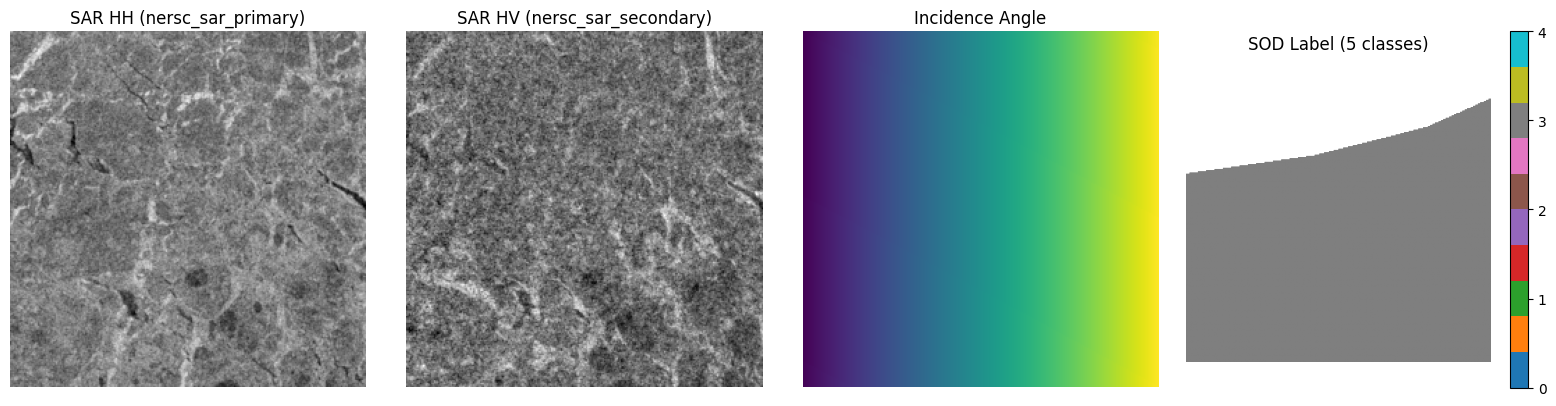

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# SAR HH
axes[0].imshow(image[0], cmap='gray')
axes[0].set_title('SAR HH (nersc_sar_primary)')
axes[0].axis('off')

# SAR HV
axes[1].imshow(image[1], cmap='gray')
axes[1].set_title('SAR HV (nersc_sar_secondary)')
axes[1].axis('off')

# Incidence Angle
axes[2].imshow(image[2], cmap='viridis')
axes[2].set_title('Incidence Angle')
axes[2].axis('off')

# SOD Label (mask out 255)
label_vis = label.numpy().astype(float)
label_vis[label_vis == 255] = np.nan
im = axes[3].imshow(label_vis, cmap='tab10', vmin=0, vmax=4)
axes[3].set_title('SOD Label (5 classes)')
axes[3].axis('off')
plt.colorbar(im, ax=axes[3], ticks=[0,1,2,3,4])

plt.tight_layout()
plt.show()

## 4. Visualize Multiple Samples

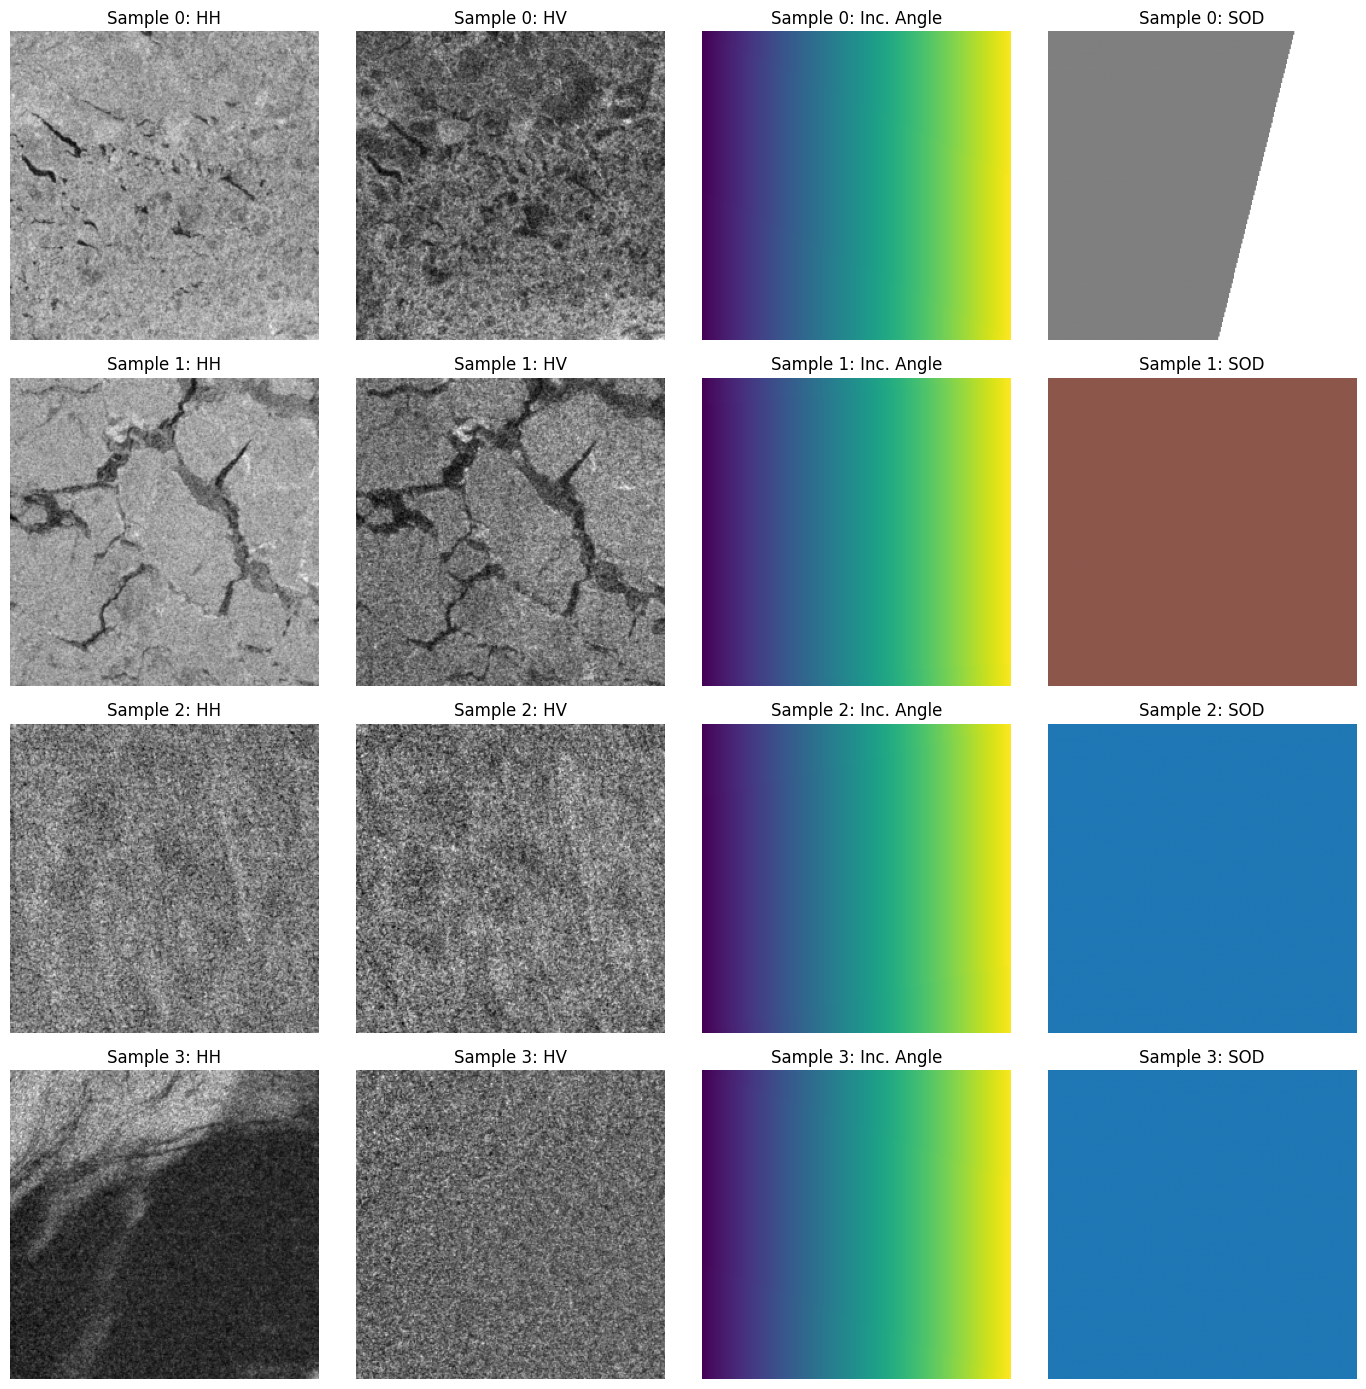

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i in range(4):
    sample = dataset[i]
    image = sample['image']
    label = sample['label'].numpy().astype(float)
    label[label == 255] = np.nan
    
    axes[i, 0].imshow(image[0], cmap='gray')
    axes[i, 0].set_title(f'Sample {i}: HH')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(image[1], cmap='gray')
    axes[i, 1].set_title(f'Sample {i}: HV')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(image[2], cmap='viridis')
    axes[i, 2].set_title(f'Sample {i}: Inc. Angle')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(label, cmap='tab10', vmin=0, vmax=4)
    axes[i, 3].set_title(f'Sample {i}: SOD')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

## 5. Test DataLoader

In [7]:
train_loader, val_loader = get_dataloaders(
    DATA_DIR,
    batch_size=8,
    num_workers=0,  # Use 0 for notebook
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total files: 512
Train files: 435
Val files:   77
Train batches: 54
Val batches: 10


In [8]:
# Get one batch
batch = next(iter(train_loader))

print(f"Batch image shape: {batch['image'].shape}")  # [B, 3, 256, 256]
print(f"Batch label shape: {batch['label'].shape}")  # [B, 256, 256]

Batch image shape: torch.Size([8, 3, 256, 256])
Batch label shape: torch.Size([8, 256, 256])


## 6. Class Distribution

In [9]:
# Count pixels per class across multiple samples
class_counts = {i: 0 for i in range(5)}
ignore_count = 0

for i in range(min(50, len(dataset))):
    label = dataset[i]['label'].numpy()
    for c in range(5):
        class_counts[c] += (label == c).sum()
    ignore_count += (label == 255).sum()

total = sum(class_counts.values())

print("Class Distribution (50 samples):")
print("="*40)
class_names = ['Open Water', 'New Ice', 'Young Ice', 'First-Year', 'Multi-Year']
for c, name in enumerate(class_names):
    pct = class_counts[c] / total * 100 if total > 0 else 0
    print(f"  {c}: {name:12s} - {pct:5.1f}%")
print(f"\n  Ignore (255): {ignore_count / (total + ignore_count) * 100:.1f}%")

Class Distribution (50 samples):
  0: Open Water   -  75.2%
  1: New Ice      -   3.6%
  2: Young Ice    -   4.3%
  3: First-Year   -   5.1%
  4: Multi-Year   -  11.8%

  Ignore (255): 18.0%


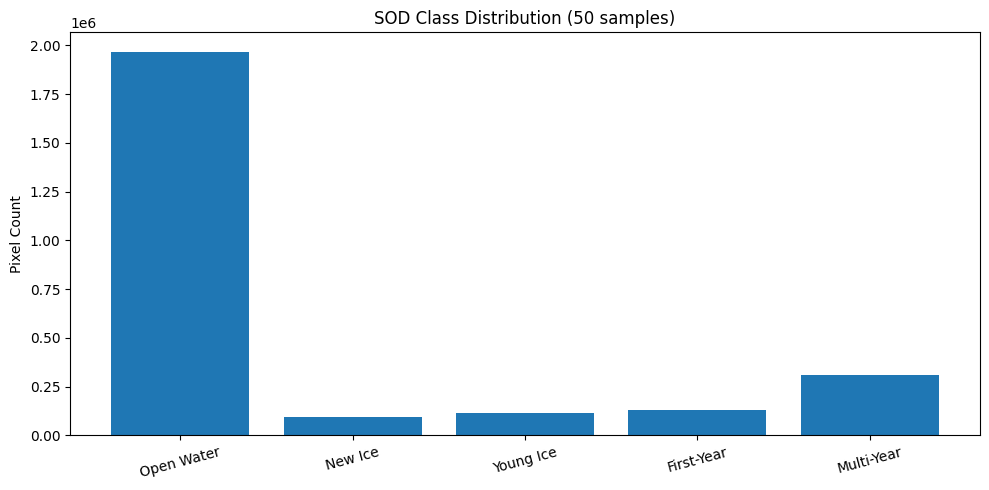

In [10]:
# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(class_names, [class_counts[i] for i in range(5)])
ax.set_ylabel('Pixel Count')
ax.set_title('SOD Class Distribution (50 samples)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 7. Summary

Dataset is ready for training:
- ✅ 3 input channels (HH, HV, incidence angle)
- ✅ 5 SOD classes (0-4)
- ✅ Ignore index = 255
- ✅ Random 256×256 crops
- ✅ Data augmentation (flips, rotations)